# Facial Anti-Spoofing using Deep Neural Network Approaches

In [1]:
import os
import shutil
import evaluate
import numpy as np
import time
import copy
import json
from PIL import Image

/Users/jasminecjwchen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jasminecjwchen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
from transformers import ViTConfig, ViTModel, ViTImageProcessor, ViTForImageClassification
from transformers import AutoImageProcessor
from transformers import TrainingArguments, Trainer

## Preparing Data Loaders

In [53]:
class SpoofDataset(Dataset):
    def __init__(self, data_dir, label_file, transform=None):
        """
        Args:
            data_dir: Directory with all the images, separated into 'live' and 'spoof' subdirectories.
            label_file: Path to JSON file with labels, where label 0 indicates 'live' and others indicate 'spoof'.
            transform: Optional transform.
        """
        self.data_dir = data_dir
        self.transform = transform
        with open(label_file, 'r') as f:
            self.labels = json.load(f)

        self.img_paths = []
        self.img_labels = []
        self.features_list = []
        for img_name, features in self.labels.items():
            # Correct the file extension from .png to .jpg
            #img_name = img_name.replace('.png', '.jpg')
            
            # final item in feature is for live vs spoof
            label = features[-1]
            subfolder = 'live' if label == 0 else 'spoof'
            full_path = os.path.join(self.data_dir, subfolder, img_name)
            
            if os.path.exists(full_path):
                self.img_paths.append(full_path)
                self.img_labels.append(label)
                self.features_list.append(features[:-1])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        label = self.img_labels[idx]
        features = self.features_list[idx]

        return image, label, features


In [76]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ToPILImage()
])

In [77]:
data_dir = "/Users/jasminecjwchen/Documents/GitHub/COMS-4995-ACV-Project/preprocessed_data"
test_dir = "/Users/jasminecjwchen/Documents/GitHub/COMS-4995-ACV-Project/unseen_data"
output_dir = '/Users/jasminecjwchen/Documents/GitHub/COMS-4995-ACV-Project/split_data'

In [80]:
label_file = "/Users/jasminecjwchen/Documents/GitHub/COMS-4995-ACV-Project/preprocessing/test_labels v2.json"
dataset = SpoofDataset(data_dir, label_file, data_transforms)

In [81]:
# splitting
num_train = int(len(dataset) * 0.8)
num_val = len(dataset) - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

In [88]:
def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))

    images = [sample[0] for sample in batch]
    labels = torch.LongTensor([sample[1] for sample in batch])
    features = torch.stack([torch.Tensor(sample[2]) for sample in batch])
    
    return images, labels, features

In [91]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, collate_fn=collate_fn),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True, collate_fn=collate_fn)
}

In [92]:
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

In [71]:
# from torch.utils.data import DataLoader
# from torchvision.datasets import ImageFolder
# from torchvision import transforms, datasets

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.ToPILImage()
# ])

# train_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'train'), transform=transform)
# val_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'val'), transform=transform)
# test_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'test'), transform=transform)

In [72]:
# def collate_fn(batch):
#     # Filter failed images first
#     batch = list(filter(lambda x: x is not None, batch))

#     images = [sample[0] for sample in batch]
#     labels = torch.LongTensor([sample[1] for sample in batch])
    
#     return images, labels

In [74]:
# phases = ["train", "val", "test"]

In [189]:
# image_datasets = {x: datasets.ImageFolder(root = os.path.join(output_dir, x), transform = transform) for x in phases}
# dataset_sizes = {x: len(image_datasets[x]) for x in phases}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size = 32, shuffle = (x == "train"), collate_fn=collate_fn) for x in phases}

In [93]:
print(dataset_sizes)

{'train': 31876, 'val': 7970}


## VIT

In [97]:
class VITModel(nn.Module):
    # vit config params are passed through kwargs
    def __init__(self, freeze_vit = True, **kwargs):
        super().__init__()
        
        self.tokenizer = ViTImageProcessor()
        
        vit_config = ViTConfig(**kwargs)
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.logistic = nn.Linear(151296, 5)
        
        if freeze_vit: 
            for param in self.model.parameters():
                param.requires_grad = False
    
    def forward(self, image):
        encoded_image = self.tokenizer(image, return_tensors = "pt")
        model_output = self.model(**encoded_image)
        
        flattened_output = model_output.last_hidden_state.flatten(start_dim = 1)
        #print(flattened_output.shape)
        return self.logistic(flattened_output)

## Training

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
use_gpu = (device != "cpu")

Using cpu


In [99]:
def train_model(model, optimizer, criterion = None, scheduler = None, dataloaders = dataloaders, num_epochs = 1, patience = 10, output_filename = "best_model.pth"):    
    since = time.time()
    
    # Initialize best metrics tracking
    best_metrics = {
        'epoch': 0,
        'val_loss': float('inf'),
        'val_accuracy': 0,
        'val_precision': 0,
        'val_recall': 0,
        'val_f1': 0,
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    if not criterion:
        criterion = nn.CrossEntropyLoss()
    
    # use patience for early stopping when validation isnt getting better
    patience_left = patience

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for image, labels, features in dataloaders[phase]:
                if use_gpu:
                    labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(image)
                    preds = torch.argmax(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * len(image)
                #print(running_loss, running_corrects)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = accuracy_score(all_labels, all_preds)
            epoch_precision = precision_score(all_labels, all_preds, zero_division=0, average='macro')
            epoch_recall = recall_score(all_labels, all_preds, zero_division=0, average='macro')
            epoch_f1 = f1_score(all_labels, all_preds, zero_division=0, average='macro')

            epoch_time = time.time() - epoch_start_time

            # deep copy the model if it's best so far
            if phase == "val" and (epoch_loss < best_metrics['val_loss'] or epoch_recall > best_metrics['val_recall']):
                best_metrics.update({
                    'epoch': epoch + 1,
                    'val_loss': epoch_loss,
                    'val_accuracy': epoch_accuracy,
                    'val_precision': epoch_precision,
                    'val_recall': epoch_recall,
                    'val_f1': epoch_f1,
                })
                
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), output_filename)
                patience_left = patience
            elif phase == "val":
                patience_left -= 1
            
            print(f'Epoch {epoch}/{num_epochs - 1} {phase} complete in {epoch_time:.4f} seconds. {phase} loss: {epoch_loss:.4f} recall: {epoch_recall:.4f}. Patience left: {patience_left}')
            
        if patience_left <= 0:
            print("Ran out of patience. Stopping early")
            break
        
        if scheduler:
            scheduler.step()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"Best Metrics at Epoch {best_metrics['epoch']}:")
    for metric, value in best_metrics.items():
        if metric != 'epoch':
            print(f"{metric.capitalize()}: {value:.4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [100]:
model = VITModel(hidden_size = 10, num_hidden_layers = 2, num_attention_heads = 2, intermediate_size = 100, num_classes = 2)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [101]:
train_model(model, optimizer, output_filename = "vit_multiclass_v1.pth")

KeyboardInterrupt: 

----

In [ ]:
import numpy as np

num_epochs = 10
patience = 2 
best_val_loss = np.inf
patience_counter = 0 

criterion = nn.CrossEntropyLoss()  # should experiment with other loss functions...
optimizer = optim.Adam(model.parameters(), lr=0.001)  # experiment with learning rate and more...

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device...") 

Using cpu device...


In [ ]:
import torch.nn.functional as F
import torch
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from torch.nn.functional import softmax

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    model.eval()
    val_running_loss = 0.0
    true_labels = []
    pred_labels = []
    pred_probs = []  # Store predicted probabilities for AUC computation
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            probs = softmax(outputs, dim=1) # softmax for ROC-AUC
            pred_probs.extend(probs[:, 1].cpu().numpy())  
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    val_loss = val_running_loss / len(val_loader.dataset)
    val_recall = recall_score(true_labels, pred_labels, average='binary')
    val_precision = precision_score(true_labels, pred_labels, average='binary')
    val_f1 = f1_score(true_labels, pred_labels, average='binary')
    val_roc_auc = roc_auc_score(true_labels, pred_probs)  
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, F1 Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/10, Training Loss: 0.0403, Validation Loss: 0.0399, Recall: 0.9955, Precision: 0.9864, F1 Score: 0.9909, ROC-AUC: 0.9978
Epoch 2/10, Training Loss: 0.0218, Validation Loss: 0.0860, Recall: 0.9979, Precision: 0.9742, F1 Score: 0.9859, ROC-AUC: 0.9956
Epoch 3/10, Training Loss: 0.0164, Validation Loss: 0.0529, Recall: 0.9935, Precision: 0.9892, F1 Score: 0.9913, ROC-AUC: 0.9976
Early stopping triggered.


## Visualizing Predictions...

### Samples selected as the first batch from the DataLoader

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

model = CNNModel()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [ ]:
def show_visualizations(num_rows=3, num_cols=8):
    num_images = num_rows * num_cols
    
    fig = plt.figure(figsize=(2.5*num_cols, 2.5*num_rows)) 
    
    for idx in range(num_images):
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[]) 
        imshow(images[idx])
        ax.set_title(f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}", fontsize=10)

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

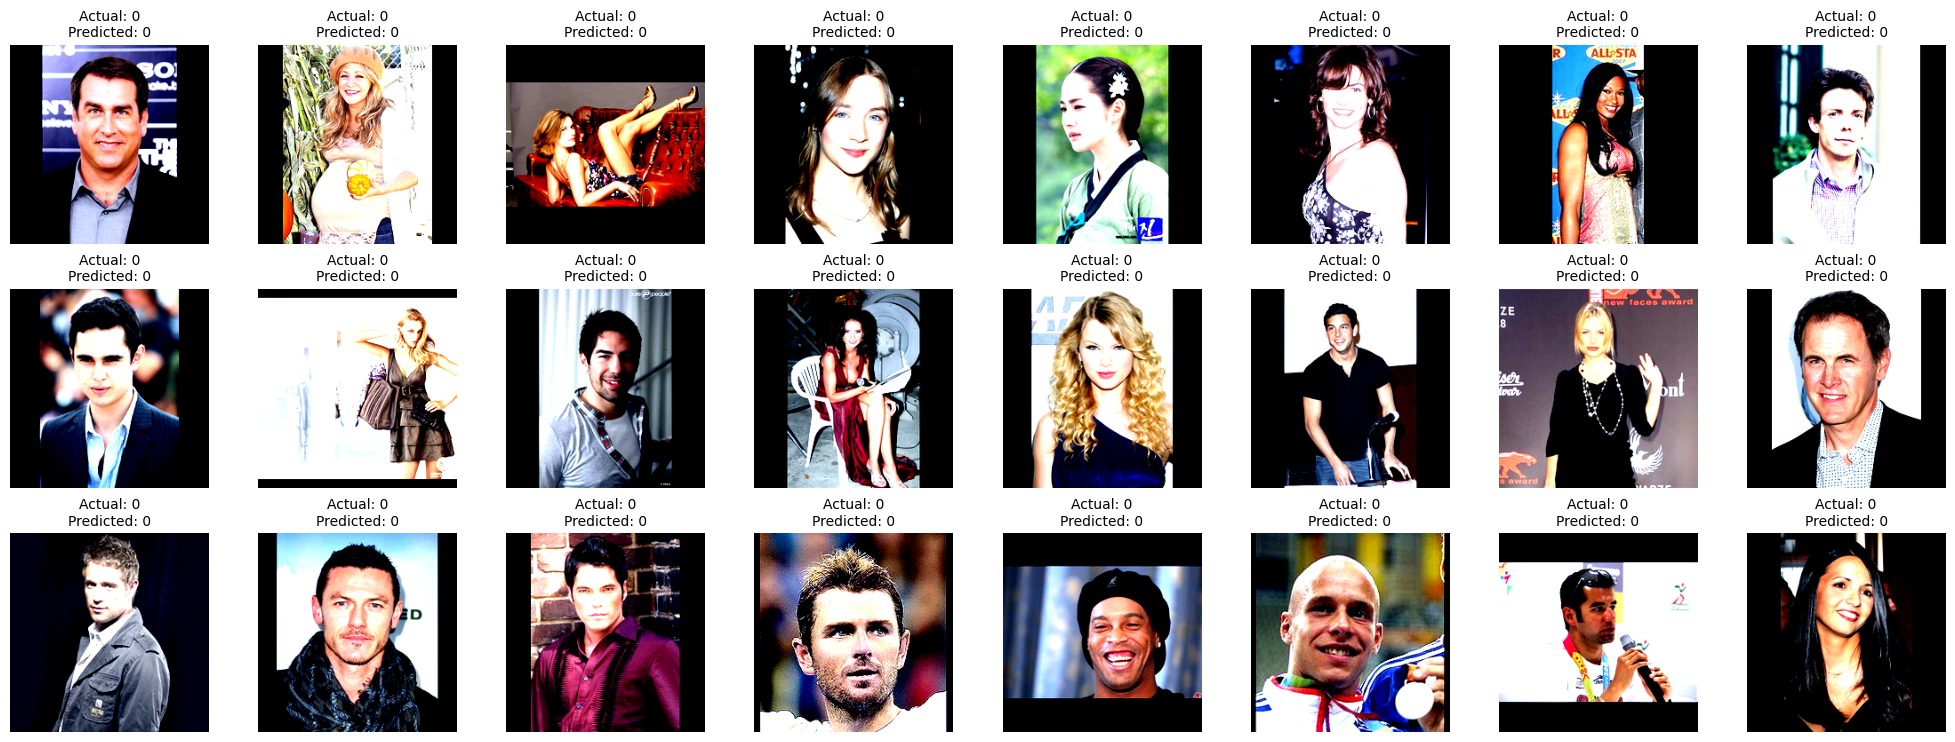

In [ ]:
show_visualizations()

### Randomly sample indices without replacement

In [ ]:
import torch
import numpy as np

num_samples_to_visualize = 30  
total_samples = len(val_dataset)  

random_indices = np.random.choice(total_samples, num_samples_to_visualize, replace=False)

In [ ]:
from torch.utils.data import Subset

visualization_subset = Subset(val_dataset, random_indices)
visualization_loader = DataLoader(visualization_subset, batch_size=num_samples_to_visualize, shuffle=False)

In [ ]:
images, labels = next(iter(visualization_loader))

model.eval()  
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

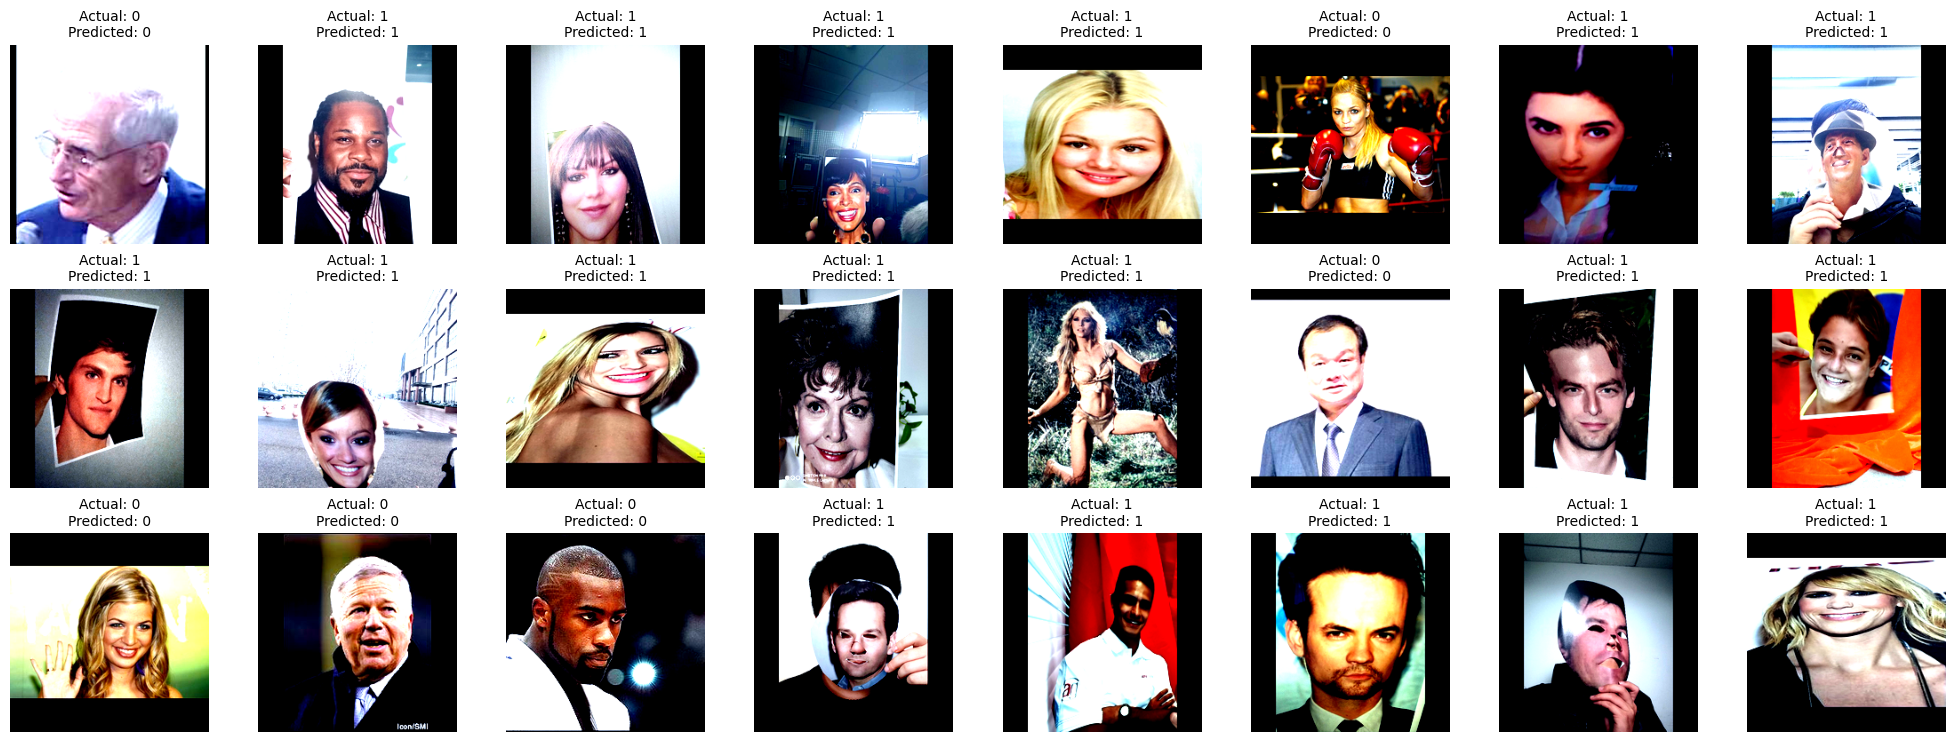

In [ ]:
show_visualizations()